In [1]:
from model import Network
from data import load_tiny_imagenet_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_tiny_imagenet_instance.json'
checkpoint_path = './checkpoints/010424_fc1_cocktail_party_tiny_imagenet_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4

_, val_dataloader = load_tiny_imagenet_dataloaders(batch_size)
data_dict = next(iter(val_dataloader))
selected_val_batch_data, selected_val_batch_label = data_dict['image'], data_dict['label']
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

The dataset is already installed


In [3]:
selected_val_batch_data.shape

torch.Size([4, 3, 64, 64])

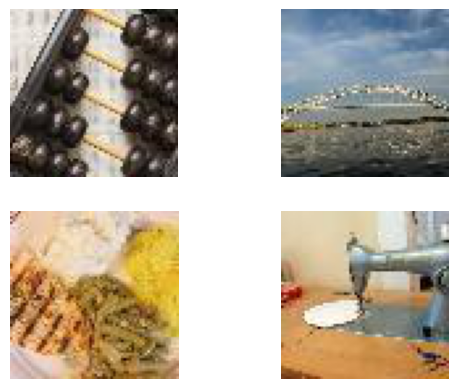

In [4]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 64, 64))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [5]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 12288]), torch.Size([200, 256])]


In [6]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [7]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(64, 64, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.2387421131134033
loss: 1.0003787279129028
loss: 1.0002188682556152
loss: 1.0002905130386353
loss: 1.000257134437561
loss: 1.0002925395965576
loss: 1.0003443956375122
loss: 1.0003238916397095
loss: 1.0003050565719604
loss: 1.0003479719161987
loss: 1.0003243684768677
loss: 1.0003036260604858
loss: 1.0003458261489868
loss: 1.0003230571746826
loss: 1.0003033876419067
loss: 1.000346064567566
loss: 1.0003224611282349
loss: 1.000301718711853
loss: 1.0003437995910645
loss: 1.0003211498260498
loss: 1.000301480293274
loss: 1.000343680381775
loss: 1.000320553779602
loss: 1.0003000497817993
loss: 1.0003420114517212
loss: 1.0003196001052856


In [9]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [10]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True, height=64, width=64)

In [11]:
psnr_match

[tensor([1, 1]), tensor([2, 2]), tensor([0, 3]), tensor([3, 0])]

In [12]:
mean_psnr

9.044628739356995

In [13]:
psnr_is_positive

[True, False, True, False]

## LPIPS

In [14]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True, height=64, width=64)

In [15]:
lpips_match

[tensor([1, 0]), tensor([3, 2]), tensor([0, 3]), tensor([2, 1])]

In [16]:
mean_lpips

0.49078693240880966

In [17]:
lpips_is_positive

[True, True, False, False]

## Estimated images

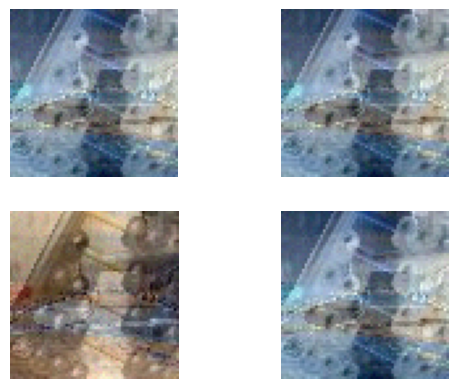

In [18]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate_idx, (estimate, ax) in enumerate(zip(estimated_img, axes.flatten())):
        estimate_coeff = 1 if lpips_is_positive[lpips_match[estimate_idx][0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 64, 64).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

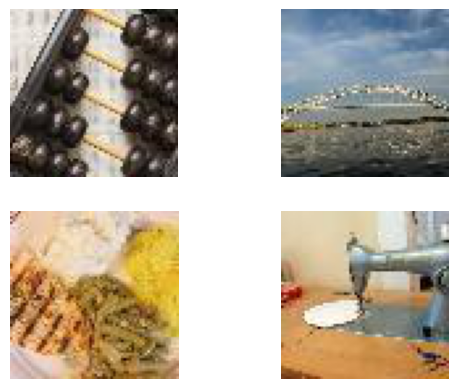

In [19]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 64, 64))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# LPIPS CPU

In [20]:
from metrics import lpips

with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True, height=64, width=64)

In [21]:
lpips_match

[tensor([1, 0]), tensor([3, 2]), tensor([0, 3]), tensor([2, 1])]

In [22]:
mean_lpips

0.4907846227288246

In [23]:
lpips_is_positive

[True, True, False, False]

## Estimated images

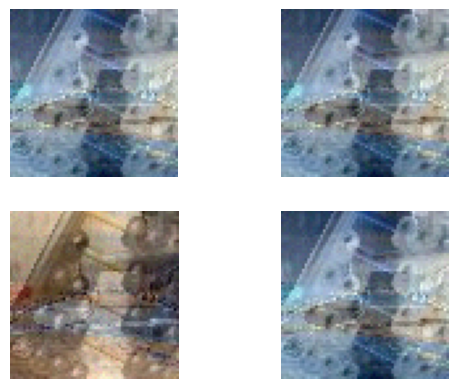

In [24]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate_idx, (estimate, ax) in enumerate(zip(estimated_img, axes.flatten())):
        estimate_coeff = 1 if lpips_is_positive[lpips_match[estimate_idx][0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 64, 64).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

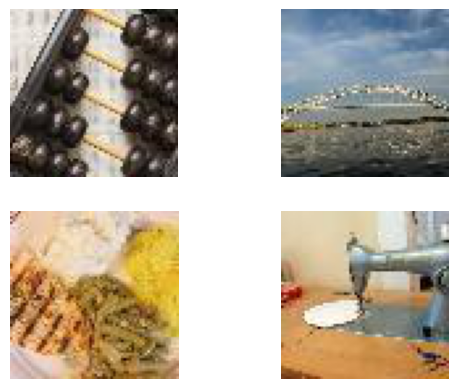

In [25]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 64, 64))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()